# Импортирование необходимых библиотек

In [1]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

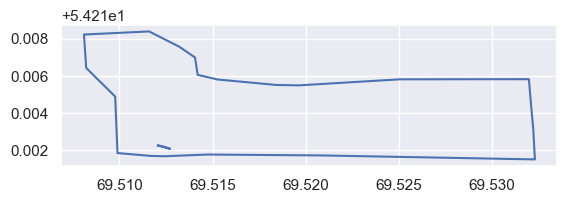

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [8]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [9]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

# Составление запросов

In [10]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
evalscript_all_bands = evalscript_all_bands.format(**settings)

In [11]:
evalscript_aux_data = """
    //VERSION=3

    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DEGREES"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in aux_data_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
evalscript_aux_data = evalscript_aux_data.format(**settings)

# Снимки на даты (с 01.05.2023 по 31.08.2023)

In [12]:
time_interval = "2020-05-01", "2020-08-31"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 49


In [13]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [14]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [15]:
aux_data_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_aux_data,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    aux_data_process_requests.append(request)

In [16]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 4min 28s


In [17]:
%%time

client = SentinelHubDownloadClient(config=config)
aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
aux_data = client.download(aux_data_download_requests)

Wall time: 6.85 s


# Составление маски пастбища

In [18]:
 aoi_height, aoi_width, _ = all_bands_data[-1].shape

In [19]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

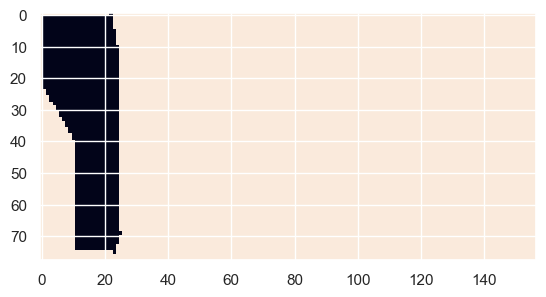

In [20]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

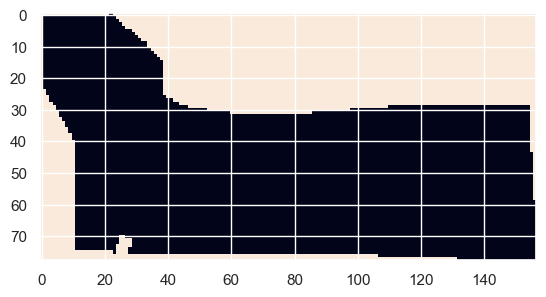

In [21]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [22]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [23]:
white_noise_threshold = 255 # Значение [0-255]  
white_noise_count = 12246 # Количество 157*78=[0-12246]

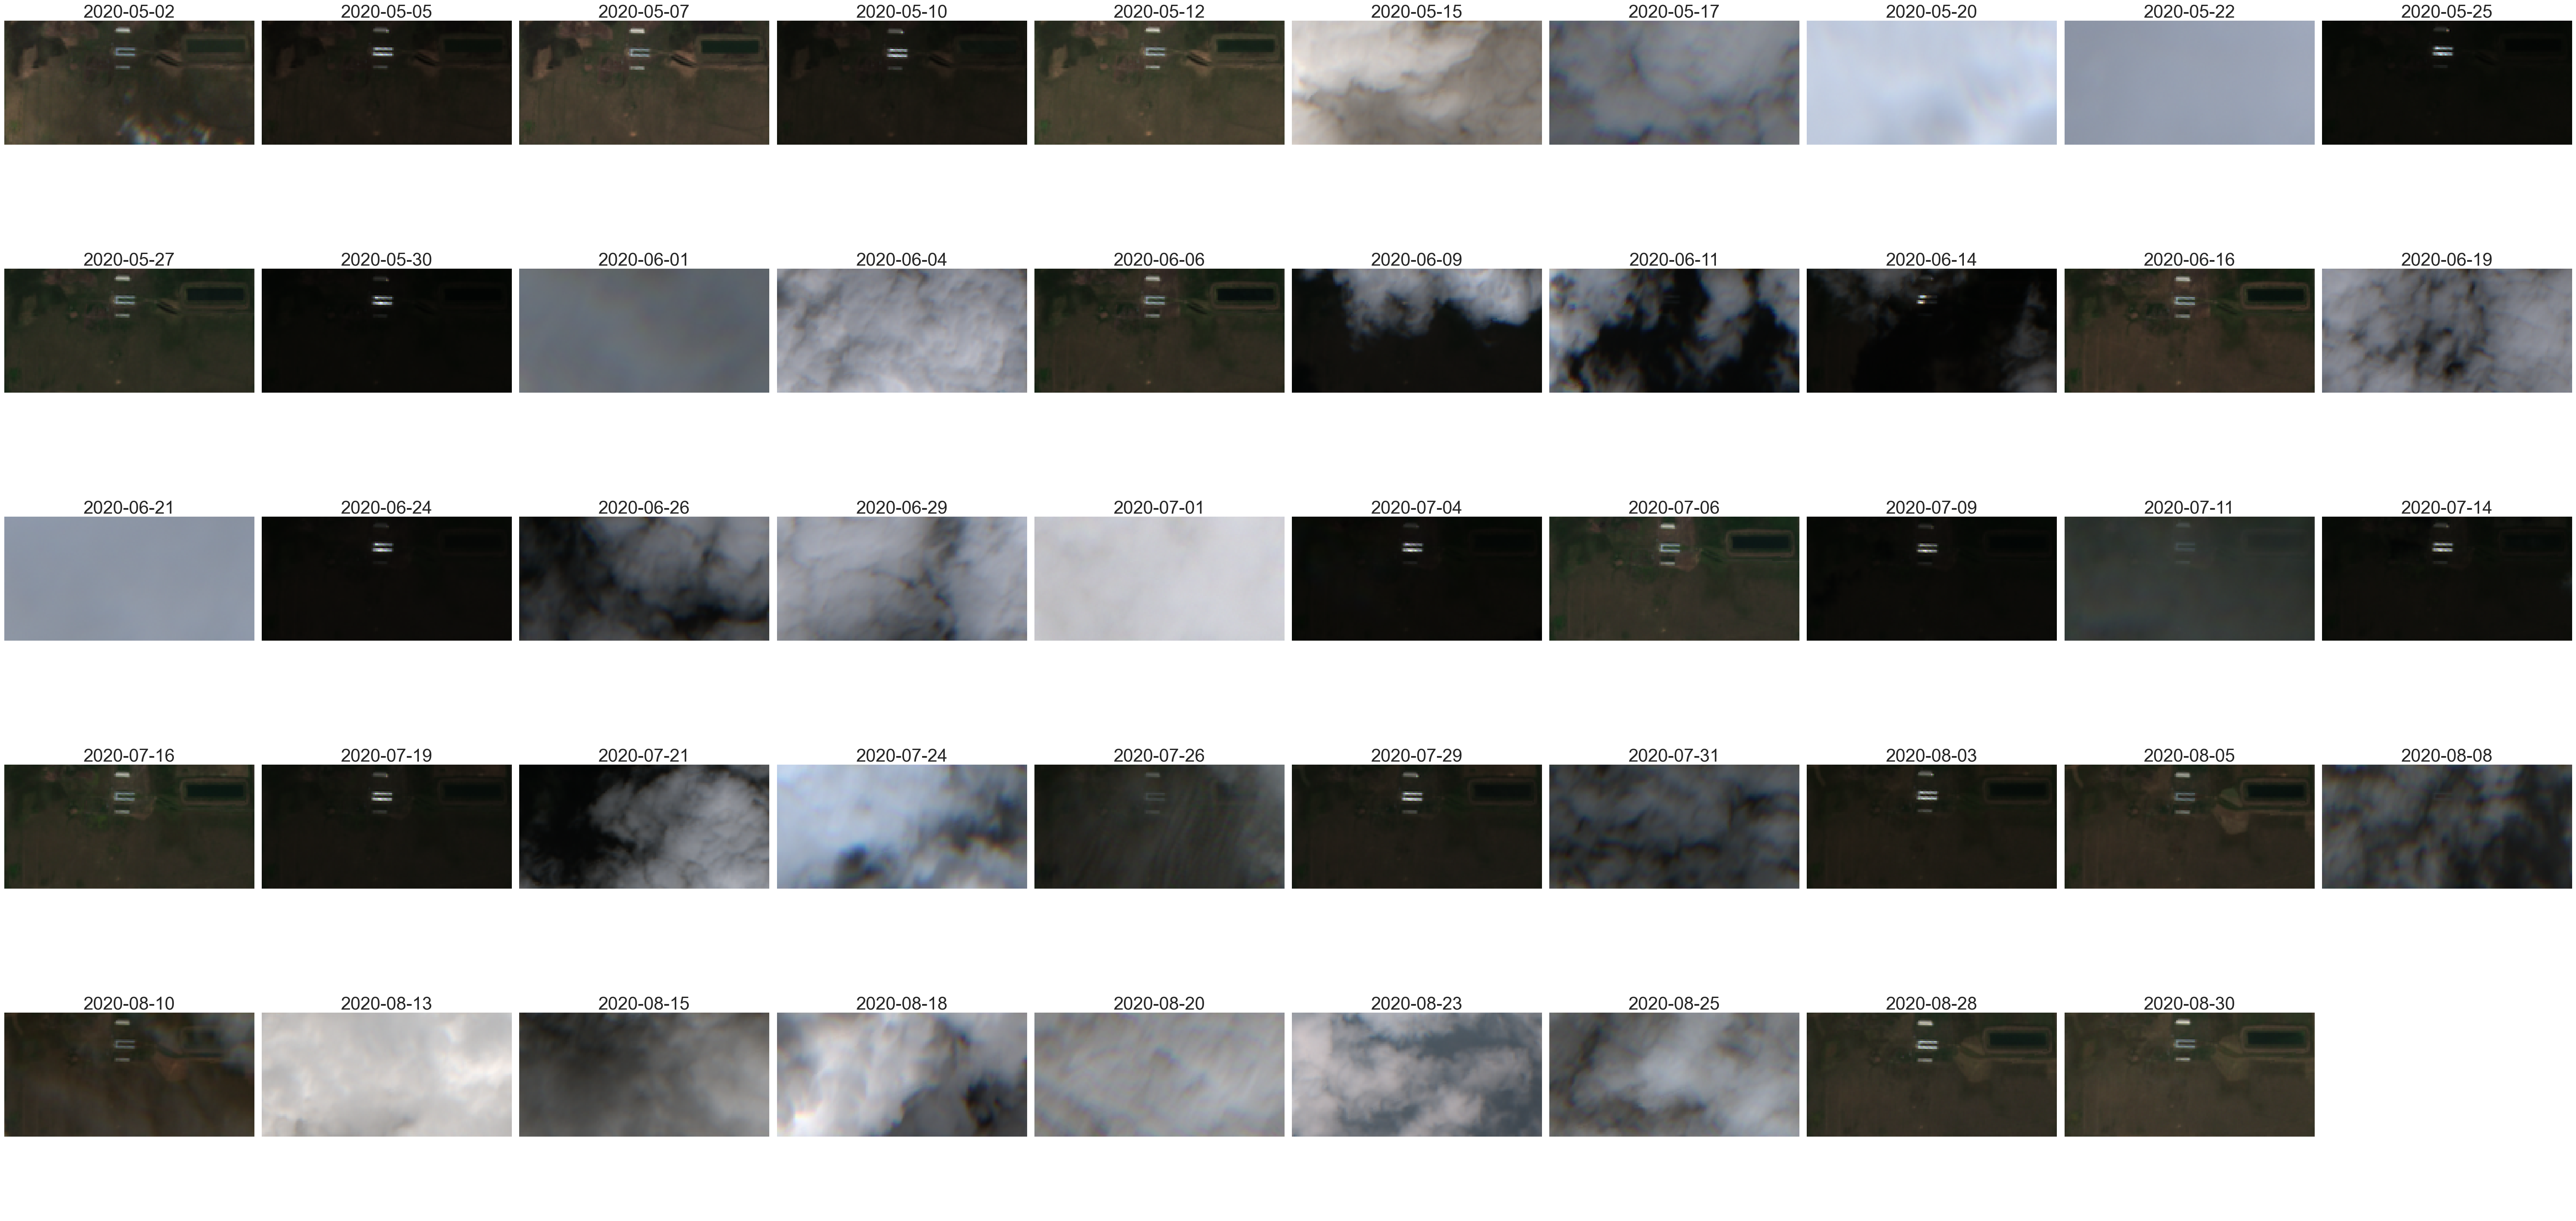

In [24]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
#     mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
#     mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
#     mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
#     comb = mx1&mx2&mx3
#     white_image = comb >= white_noise_threshold
#     if white_image.sum() <= white_noise_count:
    clear_date_dict.append((str(timestamp.date().isoformat()), i))
    ax = axis[idx // ncols][idx % ncols]
    image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
    ax.imshow(np.transpose(image, (1, 2, 0)))
    ax.set_title(timestamp.date().isoformat(), fontsize=30)
    idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Выбор доступной даты 

In [25]:
date_chosen = "2020-07-11"
image_date = clear_date_dict[date_chosen]

get_all_bands(by_pasture=False)

precision = 4
general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level}"

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_13176\1730877722.py:3: RuntimeWarning: invalid value encountered in divide
  return ((band - band_min)/((band_max - band_min)))


# Исследование нового индекса

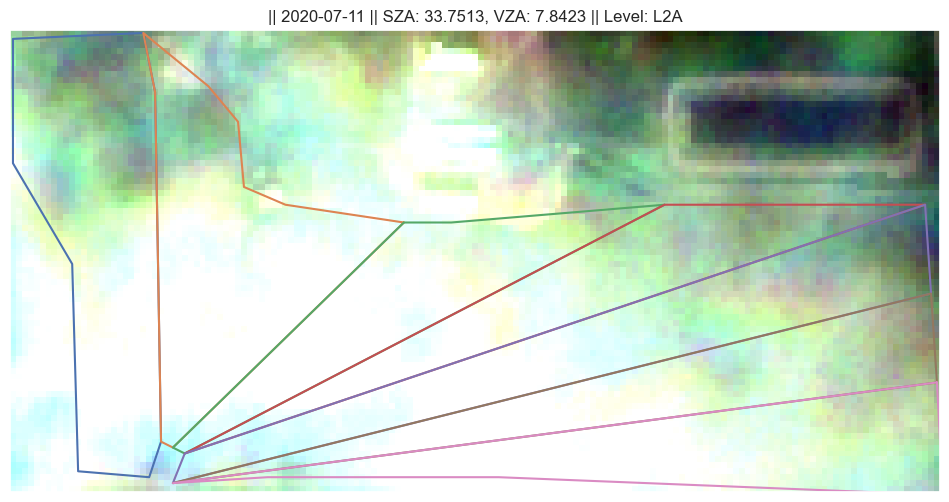

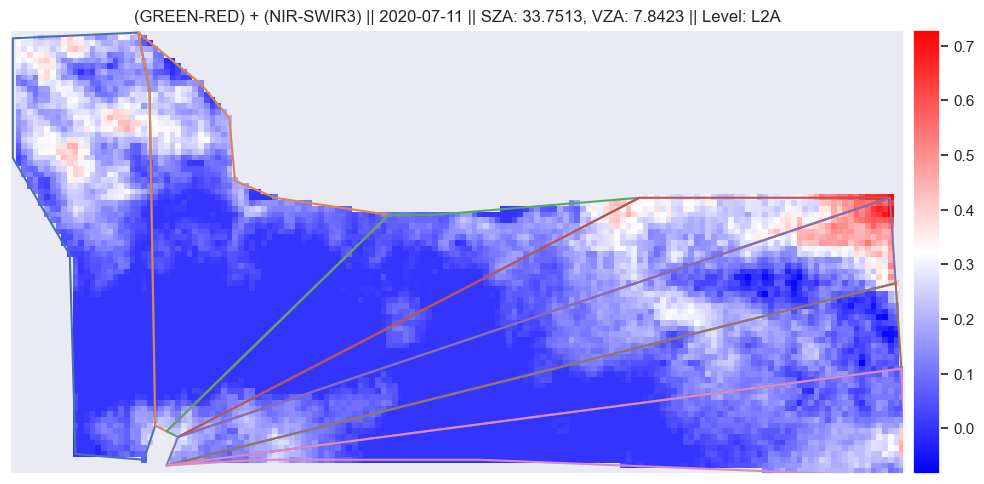

In [26]:
input_text = "(GREEN-RED) + (NIR-SWIR3)"
test_index = eval(input_text)

test_thresh = test_index.min() 
# test_thresh = (test_index.max() + test_index.min())/2

test_filter = test_index >= test_thresh; test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)

# lower_bound = -1;  upper_bound = 1
lower_bound = test_meet.min(); upper_bound = test_meet.max()

show_real_pasture()
show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False)

# Разбивка на кластеры

In [27]:
# n_clusters = 3
# for cluster_mask in Kcluster(test_meet, n_clusters):
#     cluster = ma.masked_array(test_meet, mask=cluster_mask.reshape(aoi_height, aoi_width))
#     fig, ax = plt.subplots(figsize=(12, 12))
#     for zagon in range(len(pasture_df)-1):

#         ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

#     ep.plot_bands(cluster_mask, title=f"Кластер значении [{round(float(cluster.min()),precision)} - {round(float(cluster.max()),precision)}] канала {input_text} {general_info}", ax=ax, figsize=(10, 14))
# plt.show()

# Вывод всех каналов по отдельности

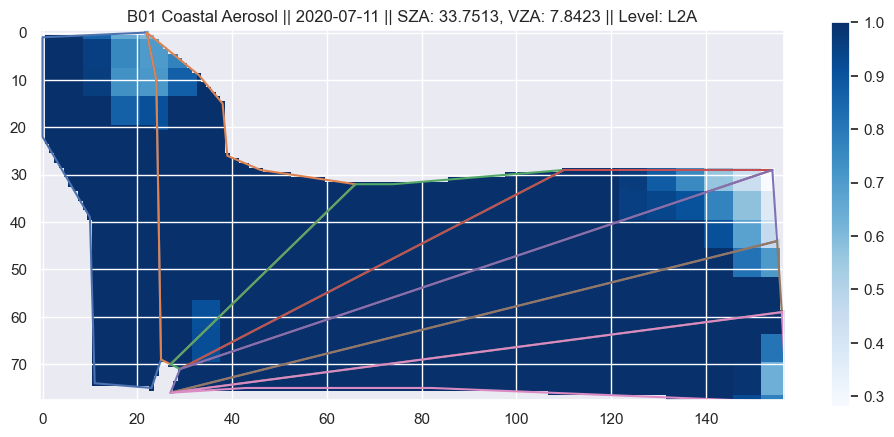

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(ULTRA_BLUE, cmap="Blues", vmin=ULTRA_BLUE.min(), vmax=ULTRA_BLUE.max())
plt.title(f"B01 Coastal Aerosol {general_info}")
plt.colorbar()
plt.show()

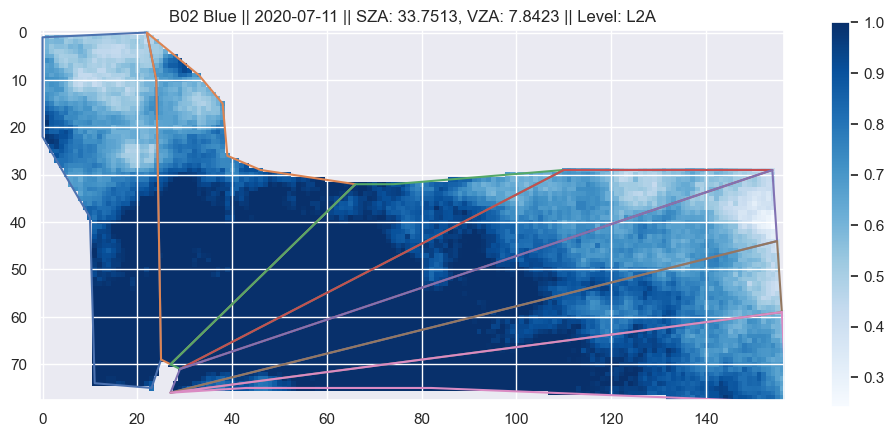

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(BLUE, cmap="Blues", vmin=BLUE.min(), vmax=BLUE.max())
plt.title(f"B02 Blue {general_info}")
plt.colorbar()
plt.show()

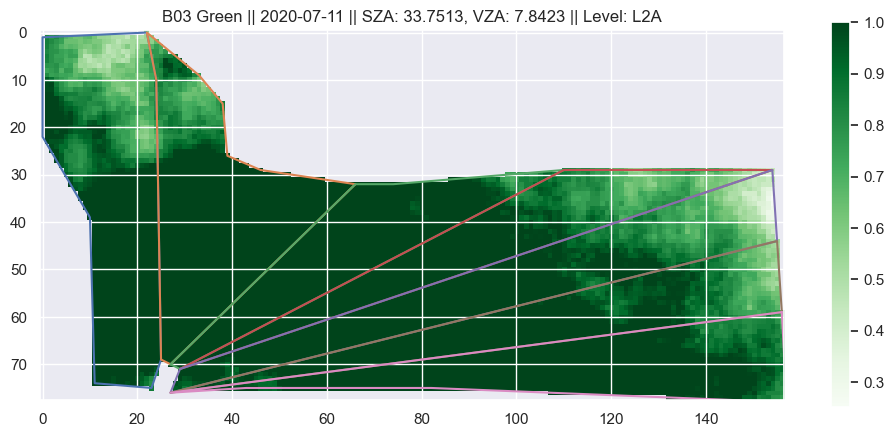

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(GREEN, cmap="Greens", vmin=GREEN.min(), vmax=GREEN.max())
plt.title(f"B03 Green {general_info}")
plt.colorbar()
plt.show()

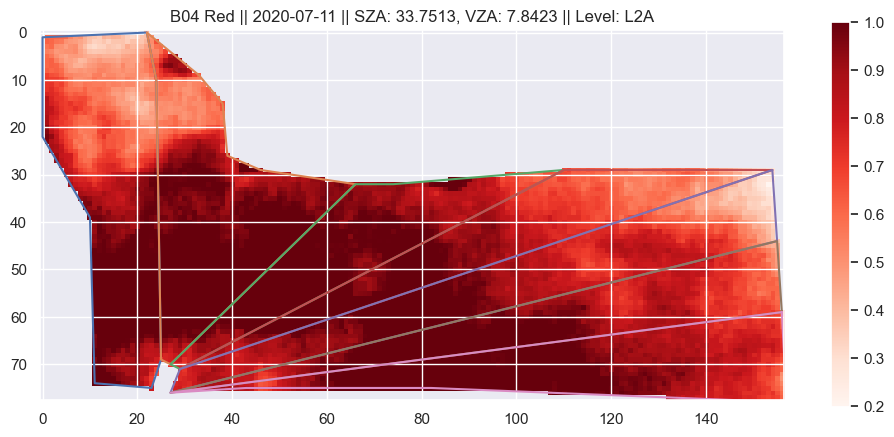

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED, cmap="Reds", vmin=RED.min(), vmax=RED.max())
plt.title(f"B04 Red {general_info}")
plt.colorbar()
plt.show()

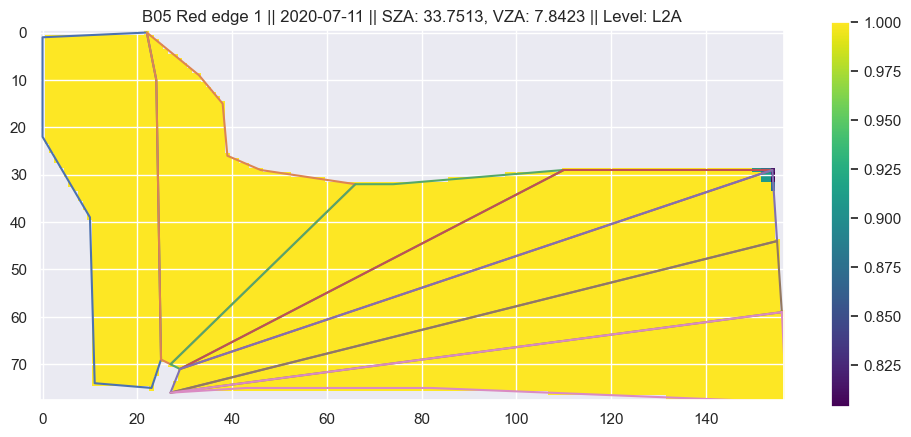

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE1, cmap="viridis", vmin=RED_EDGE1.min(), vmax=RED_EDGE1.max())
plt.title(f"B05 Red edge 1 {general_info}")
plt.colorbar()
plt.show()

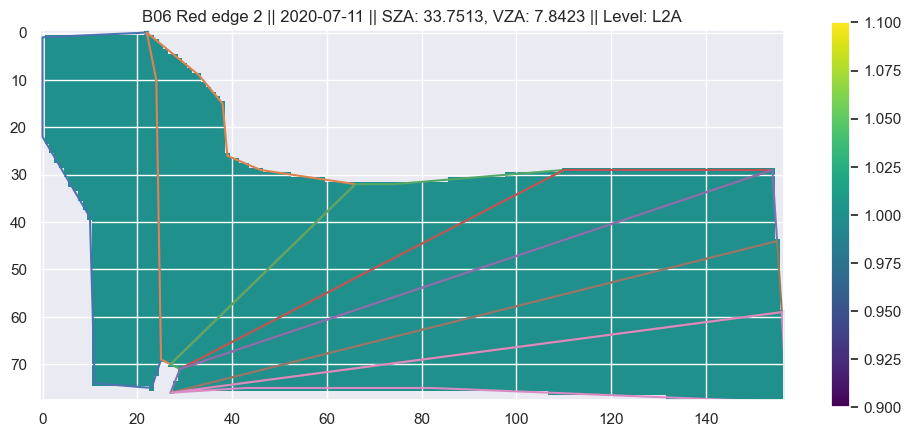

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE2, cmap="viridis", vmin=RED_EDGE2.min(), vmax=RED_EDGE2.max())
plt.title(f"B06 Red edge 2 {general_info}")
plt.colorbar()
plt.show()

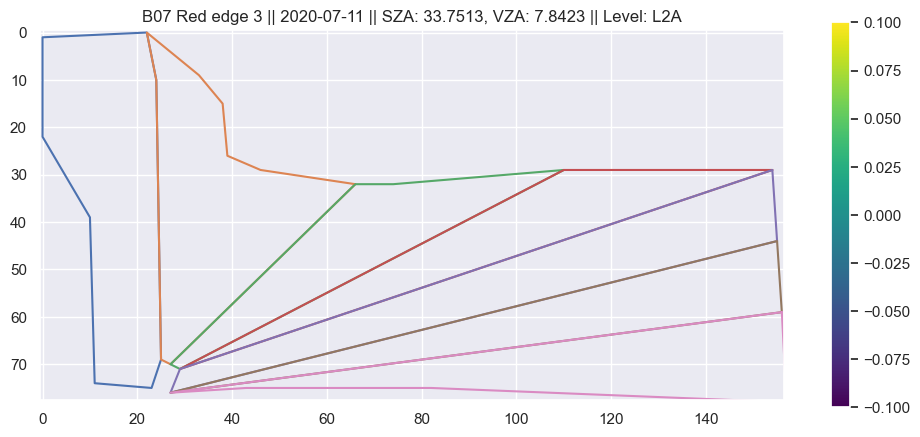

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE3, cmap="viridis", vmin=RED_EDGE3.min(), vmax=RED_EDGE3.max())
plt.title(f"B07 Red edge 3 {general_info}")
plt.colorbar()
plt.show()

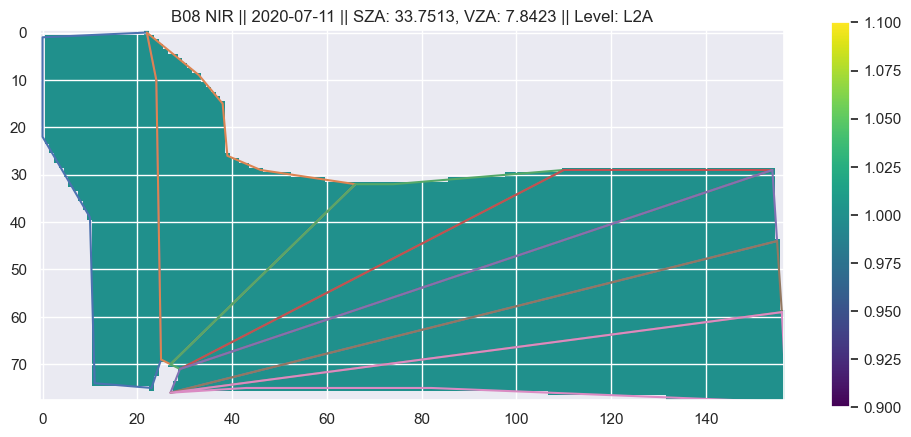

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(NIR, cmap="viridis", vmin=NIR.min(), vmax=NIR.max())
plt.title(f"B08 NIR {general_info}")
plt.colorbar()
plt.show()

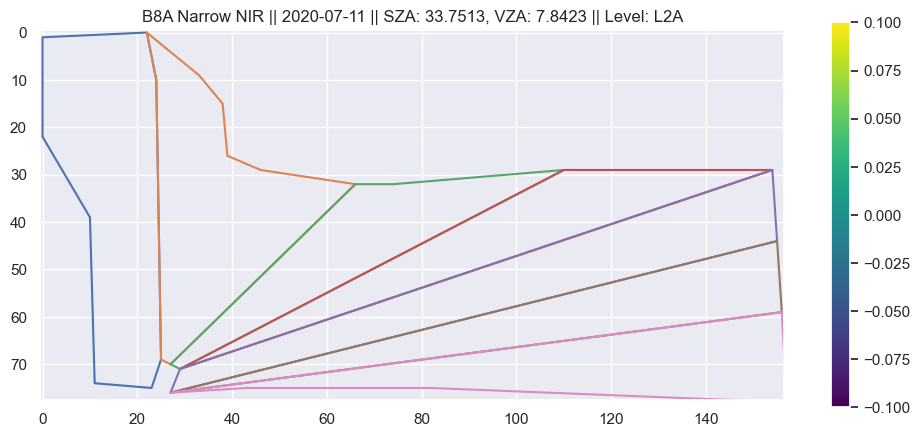

In [36]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(N_NIR, cmap="viridis", vmin=N_NIR.min(), vmax=N_NIR.max())
plt.title(f"B8A Narrow NIR {general_info}")
plt.colorbar()
plt.show()

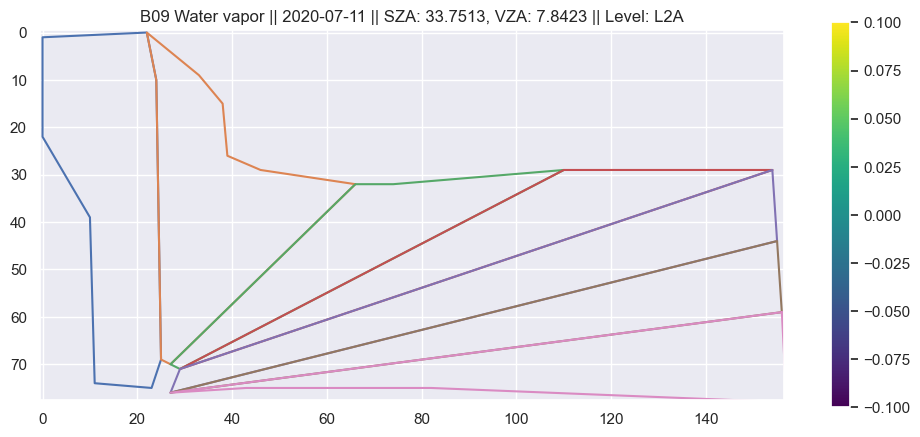

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(WV, cmap="viridis", vmin=WV.min(), vmax=WV.max())
plt.title(f"B09 Water vapor {general_info}")
plt.colorbar()
plt.show()

In [38]:
if "B10" in bands_dict:
    fig, ax = plt.subplots(figsize=(12, 5))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    plt.imshow(SWIR_C, cmap="viridis", vmin=SWIR_C.min(), vmax=SWIR_C.max())
    plt.title(f"B10 SWIR C {general_info}")
    plt.colorbar()
    plt.show()

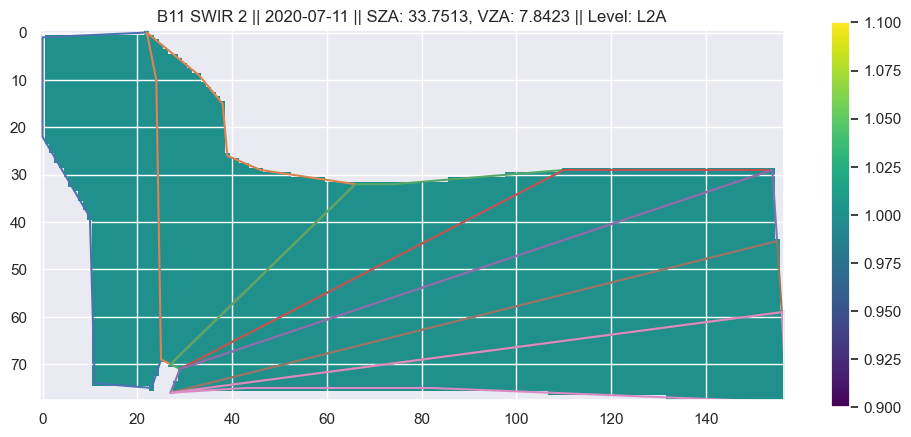

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR2, cmap="viridis", vmin=SWIR2.min(), vmax=SWIR2.max())
plt.title(f"B11 SWIR 2 {general_info}")
plt.colorbar()
plt.show()

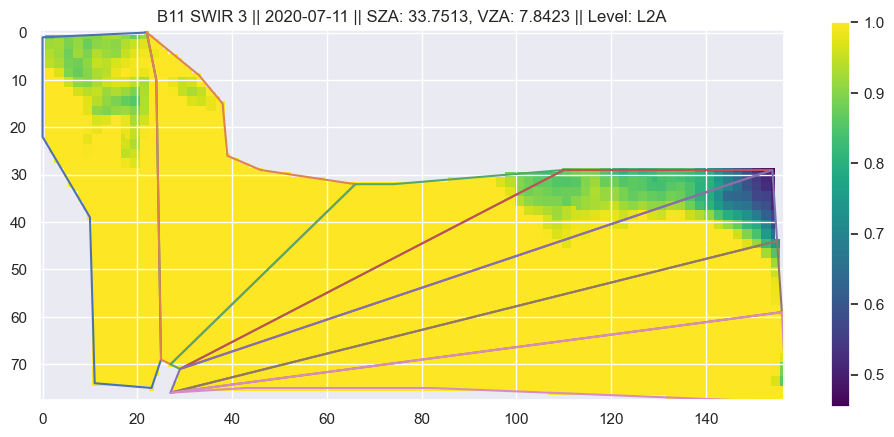

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR3, cmap="viridis", vmin=SWIR3.min(), vmax=SWIR3.max())
plt.title(f"B11 SWIR 3 {general_info}")
plt.colorbar()
plt.show()

# Анализ погодных параметров и каналов

## Координаты пастбища

In [41]:
longitude = pasture_bbox.geometry.centroid.coords.xy[0][0]
latitude = pasture_bbox.geometry.centroid.coords.xy[1][0]

In [42]:
forecast_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"showers_sum",
"snowfall_sum",
"precipitation_hours",
"precipitation_probability_max",
"precipitation_probability_min",
"precipitation_probability_mean",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",
"uv_index_max",
"uv_index_clear_sky_max",]

history_parameters = [
"temperature_2m_max",
"temperature_2m_min",
"apparent_temperature_max",
"apparent_temperature_min",
"precipitation_sum",
"rain_sum",
"snowfall_sum",
"precipitation_hours",
"weathercode",
"sunrise",
"sunset",
"windspeed_10m_max",
"windgusts_10m_max",
"winddirection_10m_dominant",
"shortwave_radiation_sum",
"et0_fao_evapotranspiration",]


last_main_description = ""

def get_weather_mapping():
    global last_main_description
    
    url = "https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    weather_mapping = {}
    
    for i_table, table in enumerate(soup.select('table[BORDER]')):
        for i_row, row in enumerate(table.find_all('tr')[1:]):
            code_and_description = row.find_all('td')[:2]
            code = int(code_and_description[0].text.strip())
            description = code_and_description[1].text.strip()
            if not description.startswith("-"):
                last_main_description = description
            else:
                description = last_main_description
            weather_mapping[code] = description
            
            
    return weather_mapping

def weather_code_to_string(wmo_code):
    return weather_mapping.get(wmo_code, "Unknown Weather Code")

# Generate the weather mapping
weather_mapping = get_weather_mapping()


def apply_params_to_URL(URL, parameters):
    URL += "&daily="
    for i, parameter in enumerate(parameters):
        if i < len(parameters) - 1:
            URL += parameter + ","
        else:
            URL += parameter
    URL += "&timezone=auto"
    
    print("URL updated: ", URL)
    return URL

def make_API_request(URL):
    try:
        # Convert from bytes to text
        resp_text = urllib.request.urlopen(URL).read().decode('UTF-8')
        # Use loads to decode from text
        json_obj = json.loads(resp_text)
        print("Successfull API request!")
        return json_obj
    except urllib.error.HTTPError  as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code, ErrorInfo)
        sys.exit()
    except  urllib.error.URLError as e:
        ErrorInfo= e.read().decode()
        print('Error code: ', e.code,ErrorInfo)
        sys.exit()

# История погоды по заданному диапазону

In [43]:
dates_to_analyze = [
    '2017-06-17',
    '2017-06-27',
    '2017-07-17',
    '2017-07-27',
    '2017-08-01',
    '2017-08-11',
    '2017-08-16',
    '2017-08-26',
    '2017-08-29',
    '2017-08-31',
    '2018-05-23',
    '2018-05-28',
    '2018-06-07',
    '2018-07-02',
    '2018-08-06',
    '2018-08-14',
    '2019-05-01',
    '2019-05-03',
    '2019-05-08',
    '2019-05-28',
    '2019-06-12',
    '2019-07-07',
    '2019-07-12',
    '2019-07-27',
    '2019-08-11',
    '2019-08-14',
    '2019-08-24',
    '2020-05-07',
    '2020-05-12',
    '2020-05-27',
    '2020-06-06',
    '2020-06-16',
    '2020-07-06',
    '2020-07-16',
    '2020-07-29',
    '2020-08-03',
    '2020-08-05',
    '2020-08-28',
    '2020-08-30',
    '2021-05-02',
    '2021-05-07',
    '2021-05-15',
    '2021-05-17',
    '2021-05-22',
    '2021-06-06',
    '2021-06-16',
    '2021-06-26',
    '2021-07-01',
    '2021-07-21',
    '2021-07-26',
    '2021-07-31',
    '2021-08-13',
    '2021-08-15',
    '2021-08-18',
    '2021-08-20',
    '2021-08-23',
    '2021-08-25',
    '2021-08-30',
    '2022-05-07',
    '2022-05-12',
    '2022-06-01',
    '2022-07-01',
    '2022-07-26',
    '2022-08-03',
    '2022-08-05',
    '2022-08-10',
    '2022-08-13',
    '2022-08-25',
    '2022-08-28',
    '2022-08-30',
    '2023-05-02',
    '2023-05-05',
    '2023-05-07',
    '2023-05-12',
    '2023-05-17',
    '2023-05-22',
    '2023-06-06',
    '2023-06-11',
    '2023-07-01',
    '2023-07-11',
    '2023-07-26',
    '2023-08-18',
    '2023-08-20',
    '2023-08-23',
]

In [44]:
start_date = "2022-05-01" 
end_date = "2022-08-31"

start_date = dates_to_analyze[0]
end_date = dates_to_analyze[-1]

In [45]:
Hist_URL = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}"

In [46]:
Hist_URL = apply_params_to_URL(Hist_URL, history_parameters)

URL updated:  https://archive-api.open-meteo.com/v1/archive?latitude=54.21495200000001&longitude=69.52020049999999&start_date=2017-06-17&end_date=2023-08-23&daily=temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,weathercode,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=auto


In [47]:
history_json_obj = make_API_request(Hist_URL)

Successfull API request!


In [48]:
history_df = pd.DataFrame(history_json_obj["daily"])

In [49]:
history_df

time  temperature_2m_max  temperature_2m_min  \
0     2017-06-17                32.3                20.1   
1     2017-06-18                33.3                20.0   
2     2017-06-19                24.7                15.9   
3     2017-06-20                25.2                17.0   
4     2017-06-21                24.7                15.7   
...          ...                 ...                 ...   
2254  2023-08-19                30.9                17.0   
2255  2023-08-20                22.9                17.0   
2256  2023-08-21                26.6                12.6   
2257  2023-08-22                22.7                16.9   
2258  2023-08-23                28.8                16.3   

      apparent_temperature_max  apparent_temperature_min  precipitation_sum  \
0                         33.7                      20.9                1.7   
1                         31.4                      19.2                1.5   
2                         20.6                      13.5                0.0   
3                         23.1                      14.4                0.1   
4                         23.7                      14.6                3.6   
...                        ...                       ...                ...   
2254                      29.1                      15.2                0.1   
2255                      22.1                      15.2                0.0   
2256                      24.4                      11.0                0.0   
2257                      20.8                      15.7                0.8   
2258                      26.1                      15.7                3.6   

      rain_sum  snowfall_sum  precipitation_hours  weathercode  \
0          1.7           0.0                  4.0           55   
1          1.5           0.0                  3.0           55   
2          0.0           0.0                  0.0            1   
3          0.1           0.0                  1.0           51   
4          3.6           0.0                  4.0           61   
...        ...           ...                  ...          ...   
2254       0.1           0.0                  1.0           51   
2255       0.0           0.0                  0.0            3   
2256       0.0           0.0                  0.0            2   
2257       0.8           0.0                  4.0           51   
2258       3.6           0.0                  9.0           61   

               sunrise            sunset  windspeed_10m_max  \
0     2017-06-17T04:47  2017-06-17T21:58               15.5   
1     2017-06-18T04:47  2017-06-18T21:58               32.6   
2     2017-06-19T04:47  2017-06-19T21:58               29.9   
3     2017-06-20T04:47  2017-06-20T21:59               21.4   
4     2017-06-21T04:47  2017-06-21T21:59               21.8   
...                ...               ...                ...   
2254  2023-08-19T06:05  2023-08-19T20:45               17.6   
2255  2023-08-20T06:07  2023-08-20T20:43               14.3   
2256  2023-08-21T06:09  2023-08-21T20:40               11.6   
2257  2023-08-22T06:11  2023-08-22T20:38               19.9   
2258  2023-08-23T06:13  2023-08-23T20:36               23.9   

      windgusts_10m_max  winddirection_10m_dominant  shortwave_radiation_sum  \
0                  36.0                         131                    25.65   
1                  59.0                         166                    24.56   
2                  61.2                         228                    24.18   
3                  50.4                         218                    22.99   
4                  54.0                         218                    21.95   
...                 ...                         ...                      ...   
2254               36.0                         272                    21.24   
2255               30.2                           7                    21.02   
2256               26.6                         142                    1

In [50]:
history_fraction_df = history_df[history_df['time'].isin(dates_to_analyze)]
history_fraction_df.reset_index(drop=True, inplace=True)
history_fraction_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_13176\3768268104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_fraction_df.drop(columns=["weathercode", "sunrise", "sunset"], inplace=True)


In [51]:
history_fraction_df

time  temperature_2m_max  temperature_2m_min  \
0   2017-06-17                32.3                20.1   
1   2017-06-27                23.4                14.9   
2   2017-07-17                20.6                13.6   
3   2017-07-27                23.7                17.8   
4   2017-08-01                27.2                13.9   
..         ...                 ...                 ...   
79  2023-07-11                37.1                21.8   
80  2023-07-26                29.2                16.7   
81  2023-08-18                26.4                13.1   
82  2023-08-20                22.9                17.0   
83  2023-08-23                28.8                16.3   

    apparent_temperature_max  apparent_temperature_min  precipitation_sum  \
0                       33.7                      20.9                1.7   
1                       21.1                      12.9                0.0   
2                       20.8                      12.3                3.1   
3                       24.9                      19.3                7.2   
4                       28.1                      13.5                0.0   
..                       ...                       ...                ...   
79                      36.5                      21.6                0.0   
80                      28.9                      16.9                1.7   
81                      25.5                      12.6                0.0   
82                      22.1                      15.2                0.0   
83                      26.1                      15.7                3.6   

    rain_sum  snowfall_sum  precipitation_hours  windspeed_10m_max  \
0        1.7           0.0                  4.0               15.5   
1        0.0           0.0                  0.0               19.6   
2        3.1           0.0                  6.0               11.2   
3        7.2           0.0                 15.0                7.4   
4        0.0           0.0                  0.0               11.8   
..       ...           ...                  ...                ...   
79       0.0           0.0                  0.0               13.8   
80       1.7           0.0                  3.0               14.8   
81       0.0           0.0                  0.0               10.9   
82       0.0           0.0                  0.0               14.3   
83       3.6           0.0                  9.0               23.9   

    windgusts_10m_max  winddirection_10m_dominant  shortwave_radiation_sum  \
0                36.0                         131                    25.65   
1                41.4                         272                    24.48   
2                22.7                         311                    19.30   
3                22.3                          23                    16.12   
4                18.7                         151                    25.83   
..                ...                         ...                      ...   
79               32.4                         215                    27.57   
80               35.3                         271                    18.77   
81               20.2                          38                    21.27   
82               30.2                           7                    21.02   
83               51.8                         193                    15.12   

    et0_fao_evapotranspiration  
0                         6.26  
1                         5.43  
2                         3.48  
3                         3.08  
4                         5.13  
..                         ...  
79                        7.64  
80                        4.23  
81                        4.17  
82                        4.32  
83                        4.36  

[84 rows x 14 columns]

# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [52]:
def get_date_data(date_chosen, collection, by_pasture=True, median=False):
    global bands_dict

    if collection == "L1C":
        data_collection = DataCollection.SENTINEL2_L1C
    elif collection == "L2A":
        data_collection = DataCollection.SENTINEL2_L2A

    bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
    aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

    evalscript_all_bands = """
        //VERSION=3
        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DN"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in bands_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
    evalscript_all_bands = evalscript_all_bands.format(**settings)


    evalscript_aux_data = """
        //VERSION=3

        function setup() {{
            return {{
                input: [{{
                    bands: [{BANDS}],
                    units: "DEGREES"
                }}],
                output: {{
                    bands: {COUNT},
                    sampleType: "FLOAT32"
                }}
            }};
        }}

        function evaluatePixel(sample) {{
            return [{SAMPLE}];
        }}
    """
    template1 = ""; template2 = ""
    for band in aux_data_dict.keys():
        template1 += f'"{band}", ';
        template2 += f'sample.{band}, ';
    settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
    evalscript_aux_data = evalscript_aux_data.format(**settings)


    time_interval = date_chosen, date_chosen

    search_iterator = catalog.search(
        data_collection,
        bbox=pasture_bbox,
        time=time_interval,
        filter="eo:cloud_cover <= 100",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)

    time_difference = datetime.timedelta(hours=1)
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)


    all_bands_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_all_bands,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        all_bands_process_requests.append(request)

    aux_data_process_requests = []

    for timestamp in unique_acquisitions:
        request = SentinelHubRequest(
            evalscript=evalscript_aux_data,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=data_collection,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
            bbox=pasture_bbox,
            size=pasture_size,
            config=config,
        )
        aux_data_process_requests.append(request)

    client = SentinelHubDownloadClient(config=config)
    all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
    all_bands_data = client.download(all_bands_download_requests)

    client = SentinelHubDownloadClient(config=config)
    aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
    aux_data = client.download(aux_data_download_requests)

    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    ndvi = (NIR - RED) / (NIR + RED)
    savi = (NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5)
    revi = (NIR / RED_EDGE1) - 1
    evi = 2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)
    tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)
    gndvi = (NIR - GREEN) / (NIR + GREEN)
    ndii = (NIR - SWIR3) / (NIR + SWIR3)
    cvi = (NIR / RED) - 1
    gci = (NIR / GREEN) - 1
    pri = (RED_EDGE1 - RED) / (RED_EDGE1 + RED)
    ndre = (NIR - RED_EDGE1) / (NIR + RED_EDGE1)
    osavi = (NIR - RED) / (NIR + RED + 0.16)
    arvi = (NIR - (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)
    vari = (RED+BLUE-GREEN)
    my_index = (GREEN-RED)+(NIR-SWIR3)



    print(f"Успешно получены каналы для даты: {date_chosen}")
    if median:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR_C), ma.median(SWIR2), ma.median(SWIR3), ma.median(ndvi), ma.median(savi), ma.median(revi), ma.median(evi), ma.median(tvi), ma.median(gndvi), ma.median(ndii), ma.median(cvi), ma.median(gci), ma.median(pri), ma.median(ndre), ma.median(osavi), ma.median(arvi), ma.median(vari), ma.median(my_index), SZA, SAA, VZM, VAM]
        else:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.median(ULTRA_BLUE), ma.median(BLUE), ma.median(GREEN), ma.median(RED), ma.median(RED_EDGE1), ma.median(RED_EDGE2), ma.median(RED_EDGE3), ma.median(NIR), ma.median(N_NIR), ma.median(WV), ma.median(SWIR2), ma.median(SWIR3), ma.median(ndvi), ma.median(savi), ma.median(revi), ma.median(evi), ma.median(tvi), ma.median(gndvi), ma.median(ndii), ma.median(cvi), ma.median(gci), ma.median(pri), ma.median(ndre), ma.median(osavi), ma.median(arvi), ma.median(vari), ma.median(my_index), SZA, SAA, VZM, VAM]
    else:
        if "B10" in bands_dict:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR_C), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(ndvi), ma.mean(savi), ma.mean(revi), ma.mean(evi), ma.mean(tvi), ma.mean(gndvi), ma.mean(ndii), ma.mean(cvi), ma.mean(gci), ma.mean(pri), ma.mean(ndre), ma.mean(osavi), ma.mean(arvi), ma.mean(vari), ma.mean(my_index), SZA, SAA, VZM, VAM]
        else:
            return ["time"] + list(bands_dict.keys()) + ["ndvi", "savi", "revi", "evi", "tvi", "gndvi", "ndii", "cvi", "gci", "pri", "ndre", "osavi", "arvi", "vari", "my_index",] + list(aux_data_dict.keys()), [date_chosen, ma.mean(ULTRA_BLUE), ma.mean(BLUE), ma.mean(GREEN), ma.mean(RED), ma.mean(RED_EDGE1), ma.mean(RED_EDGE2), ma.mean(RED_EDGE3), ma.mean(NIR), ma.mean(N_NIR), ma.mean(WV), ma.mean(SWIR2), ma.mean(SWIR3), ma.mean(ndvi), ma.mean(savi), ma.mean(revi), ma.mean(evi), ma.mean(tvi), ma.mean(gndvi), ma.mean(ndii), ma.mean(cvi), ma.mean(gci), ma.mean(pri), ma.mean(ndre), ma.mean(osavi), ma.mean(arvi), ma.mean(vari), ma.mean(my_index), SZA, SAA, VZM, VAM]

# Получение данных ДЗЗ по доступным датам

In [53]:
sample_form = []
for date in dates_to_analyze:
    data_lables, data_list = get_date_data(date, "L2A", by_pasture=False, median=False)
    sample_form.append(data_list)    

Успешно получены каналы для даты: 2017-06-17
Успешно получены каналы для даты: 2017-06-27
Успешно получены каналы для даты: 2017-07-17
Успешно получены каналы для даты: 2017-07-27
Успешно получены каналы для даты: 2017-08-01
Успешно получены каналы для даты: 2017-08-11
Успешно получены каналы для даты: 2017-08-16
Успешно получены каналы для даты: 2017-08-26
Успешно получены каналы для даты: 2017-08-29
Успешно получены каналы для даты: 2017-08-31
Успешно получены каналы для даты: 2018-05-23
Успешно получены каналы для даты: 2018-05-28
Успешно получены каналы для даты: 2018-06-07
Успешно получены каналы для даты: 2018-07-02
Успешно получены каналы для даты: 2018-08-06
Успешно получены каналы для даты: 2018-08-14
Успешно получены каналы для даты: 2019-05-01
Успешно получены каналы для даты: 2019-05-03
Успешно получены каналы для даты: 2019-05-08
Успешно получены каналы для даты: 2019-05-28
Успешно получены каналы для даты: 2019-06-12
Успешно получены каналы для даты: 2019-07-07
Успешно по

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_13176\1594915382.py:198: RuntimeWarning: invalid value encountered in sqrt
  tvi = np.sqrt((NIR - RED) / (NIR + RED) + 0.0)


In [54]:
indices_df = pd.DataFrame(sample_form, columns=data_lables)
# indices_df = indices_df[indices_df != "--"].dropna()
indices_df

time       B01       B02       B03       B04       B05       B06  \
0   2017-06-17  0.167913  0.174456  0.331153  0.291861  0.622410  0.993919   
1   2017-06-27  0.206063  0.223541  0.366131  0.361138  0.662530  0.997883   
2   2017-07-17  0.250923  0.196177  0.319174  0.337958  0.665491  0.993657   
3   2017-07-27  0.219054  0.179694  0.294378  0.315081  0.613659  0.972558   
4   2017-08-01  0.224226  0.179637  0.264385  0.314703  0.573983  0.921229   
..         ...       ...       ...       ...       ...       ...       ...   
79  2023-07-11  0.382660  0.242288  0.266697  0.437959  0.634336  0.931511   
80  2023-07-26  0.419866  0.233872  0.240565  0.414733  0.512148  0.800403   
81  2023-08-18  0.324848  0.272364  0.282468  0.463389  0.482098  0.743511   
82  2023-08-20  0.442172  0.357262  0.349226  0.539774  0.523728  0.823172   
83  2023-08-23  0.466757  0.322477  0.332620  0.506265  0.602065  0.707534   

         B07       B08       B8A  ...       pri      ndre     osavi      arvi  \
0   0.997143  0.995362  0.998041  ...  0.404390  0.238553  0.500522  0.375490   
1   0.999466  0.998901  0.999687  ...  0.334912  0.208920  0.435915  0.298742   
2   0.999790  0.999405  1.000000  ...  0.356556  0.203891  0.453975  0.310456   
3   0.996376  0.998899  1.000000  ...  0.353504  0.241327  0.475490  0.335755   
4   0.973539  0.992763  0.998585  ...  0.325369  0.269934  0.473104  0.333120   
..       ...       ...       ...  ...       ...       ...       ...       ...   
79  0.991648  0.995039  0.999882  ...  0.186214  0.225016  0.352941  0.177736   
80  0.883241  0.906753  0.970493  ...  0.104471  0.282627  0.333968  0.162736   
81  0.827718  0.881016  0.960128  ...  0.011930  0.302170  0.279886  0.113669   
82  0.956015  0.999601  0.999811  ... -0.022629  0.319917  0.272896  0.117560   
83  0.831881  0.857901  0.958264  ...  0.080597  0.181082  0.230209  0.078938   

        vari  my_index  sunZenithAngles  sunAzimuthAngles  viewZenithMean  \
0   0.135164  0.282400        32.185795        158.629974        7.853477   
1   0.218548  0.176047        32.378300        157.746002        7.895983   
2   0.214961  0.125460        34.643398        157.448990        7.827316   
3   0.200396  0.105950        36.607201        158.115982        7.802473   
4   0.229954  0.073456        37.769295        158.625992        7.778082   
..       ...       ...              ...               ...             ...   
79  0.413550 -0.176114        33.651306        157.322006        7.827204   
80  0.408039 -0.266497        36.290100        157.990982        7.799461   
81  0.453285 -0.299566        41.902100        164.649994        5.196754   
82  0.547810 -0.190912        42.947605        161.427002        7.799079   
83  0.496123 -0.289914        43.490906        165.444000        5.211236   

    viewAzimuthMean  
0        115.113281  
1        115.055450  
2        115.154022  
3        115.197052  
4        116.019760  
..              ...  
79       115.996796  
80       115.212761  
81       272.815735  
82       116.025909  
83       271.589661  

[84 rows x 32 columns]

# Подготовка таблиц

In [55]:
joined_df = pd.merge(indices_df, history_fraction_df, on='time', how='outer')
joined_df

time       B01       B02       B03       B04       B05       B06  \
0   2017-06-17  0.167913  0.174456  0.331153  0.291861  0.622410  0.993919   
1   2017-06-27  0.206063  0.223541  0.366131  0.361138  0.662530  0.997883   
2   2017-07-17  0.250923  0.196177  0.319174  0.337958  0.665491  0.993657   
3   2017-07-27  0.219054  0.179694  0.294378  0.315081  0.613659  0.972558   
4   2017-08-01  0.224226  0.179637  0.264385  0.314703  0.573983  0.921229   
..         ...       ...       ...       ...       ...       ...       ...   
79  2023-07-11  0.382660  0.242288  0.266697  0.437959  0.634336  0.931511   
80  2023-07-26  0.419866  0.233872  0.240565  0.414733  0.512148  0.800403   
81  2023-08-18  0.324848  0.272364  0.282468  0.463389  0.482098  0.743511   
82  2023-08-20  0.442172  0.357262  0.349226  0.539774  0.523728  0.823172   
83  2023-08-23  0.466757  0.322477  0.332620  0.506265  0.602065  0.707534   

         B07       B08       B8A  ...  apparent_temperature_min  \
0   0.997143  0.995362  0.998041  ...                      20.9   
1   0.999466  0.998901  0.999687  ...                      12.9   
2   0.999790  0.999405  1.000000  ...                      12.3   
3   0.996376  0.998899  1.000000  ...                      19.3   
4   0.973539  0.992763  0.998585  ...                      13.5   
..       ...       ...       ...  ...                       ...   
79  0.991648  0.995039  0.999882  ...                      21.6   
80  0.883241  0.906753  0.970493  ...                      16.9   
81  0.827718  0.881016  0.960128  ...                      12.6   
82  0.956015  0.999601  0.999811  ...                      15.2   
83  0.831881  0.857901  0.958264  ...                      15.7   

    precipitation_sum  rain_sum  snowfall_sum  precipitation_hours  \
0                 1.7       1.7           0.0                  4.0   
1                 0.0       0.0           0.0                  0.0   
2                 3.1       3.1           0.0                  6.0   
3                 7.2       7.2           0.0                 15.0   
4                 0.0       0.0           0.0                  0.0   
..                ...       ...           ...                  ...   
79                0.0       0.0           0.0                  0.0   
80                1.7       1.7           0.0                  3.0   
81                0.0       0.0           0.0                  0.0   
82                0.0       0.0           0.0                  0.0   
83                3.6       3.6           0.0                  9.0   

    windspeed_10m_max  windgusts_10m_max  winddirection_10m_dominant  \
0                15.5               36.0                         131   
1                19.6               41.4                         272   
2                11.2               22.7                         311   
3                 7.4               22.3                          23   
4                11.8               18.7                         151   
..                ...                ...                         ...   
79               13.8               32.4                         215   
80               14.8               35.3                         271   
81               10.9               20.2                          38   
82               14.3               30.2                           7   
83               23.9               51.8                         193   

    shortwave_radiation_sum  et0_fao_evapotranspiration  
0                     25.65                        6.26  
1                     24.48                        5.43  
2                     19.30                        3.48  
3                     16.12                        3.08  
4                     25.83                        5.13  
..                      ...                         ...  
79                    27.57                        7.64  
80                    18.77                        4.23  
81                    21.27             

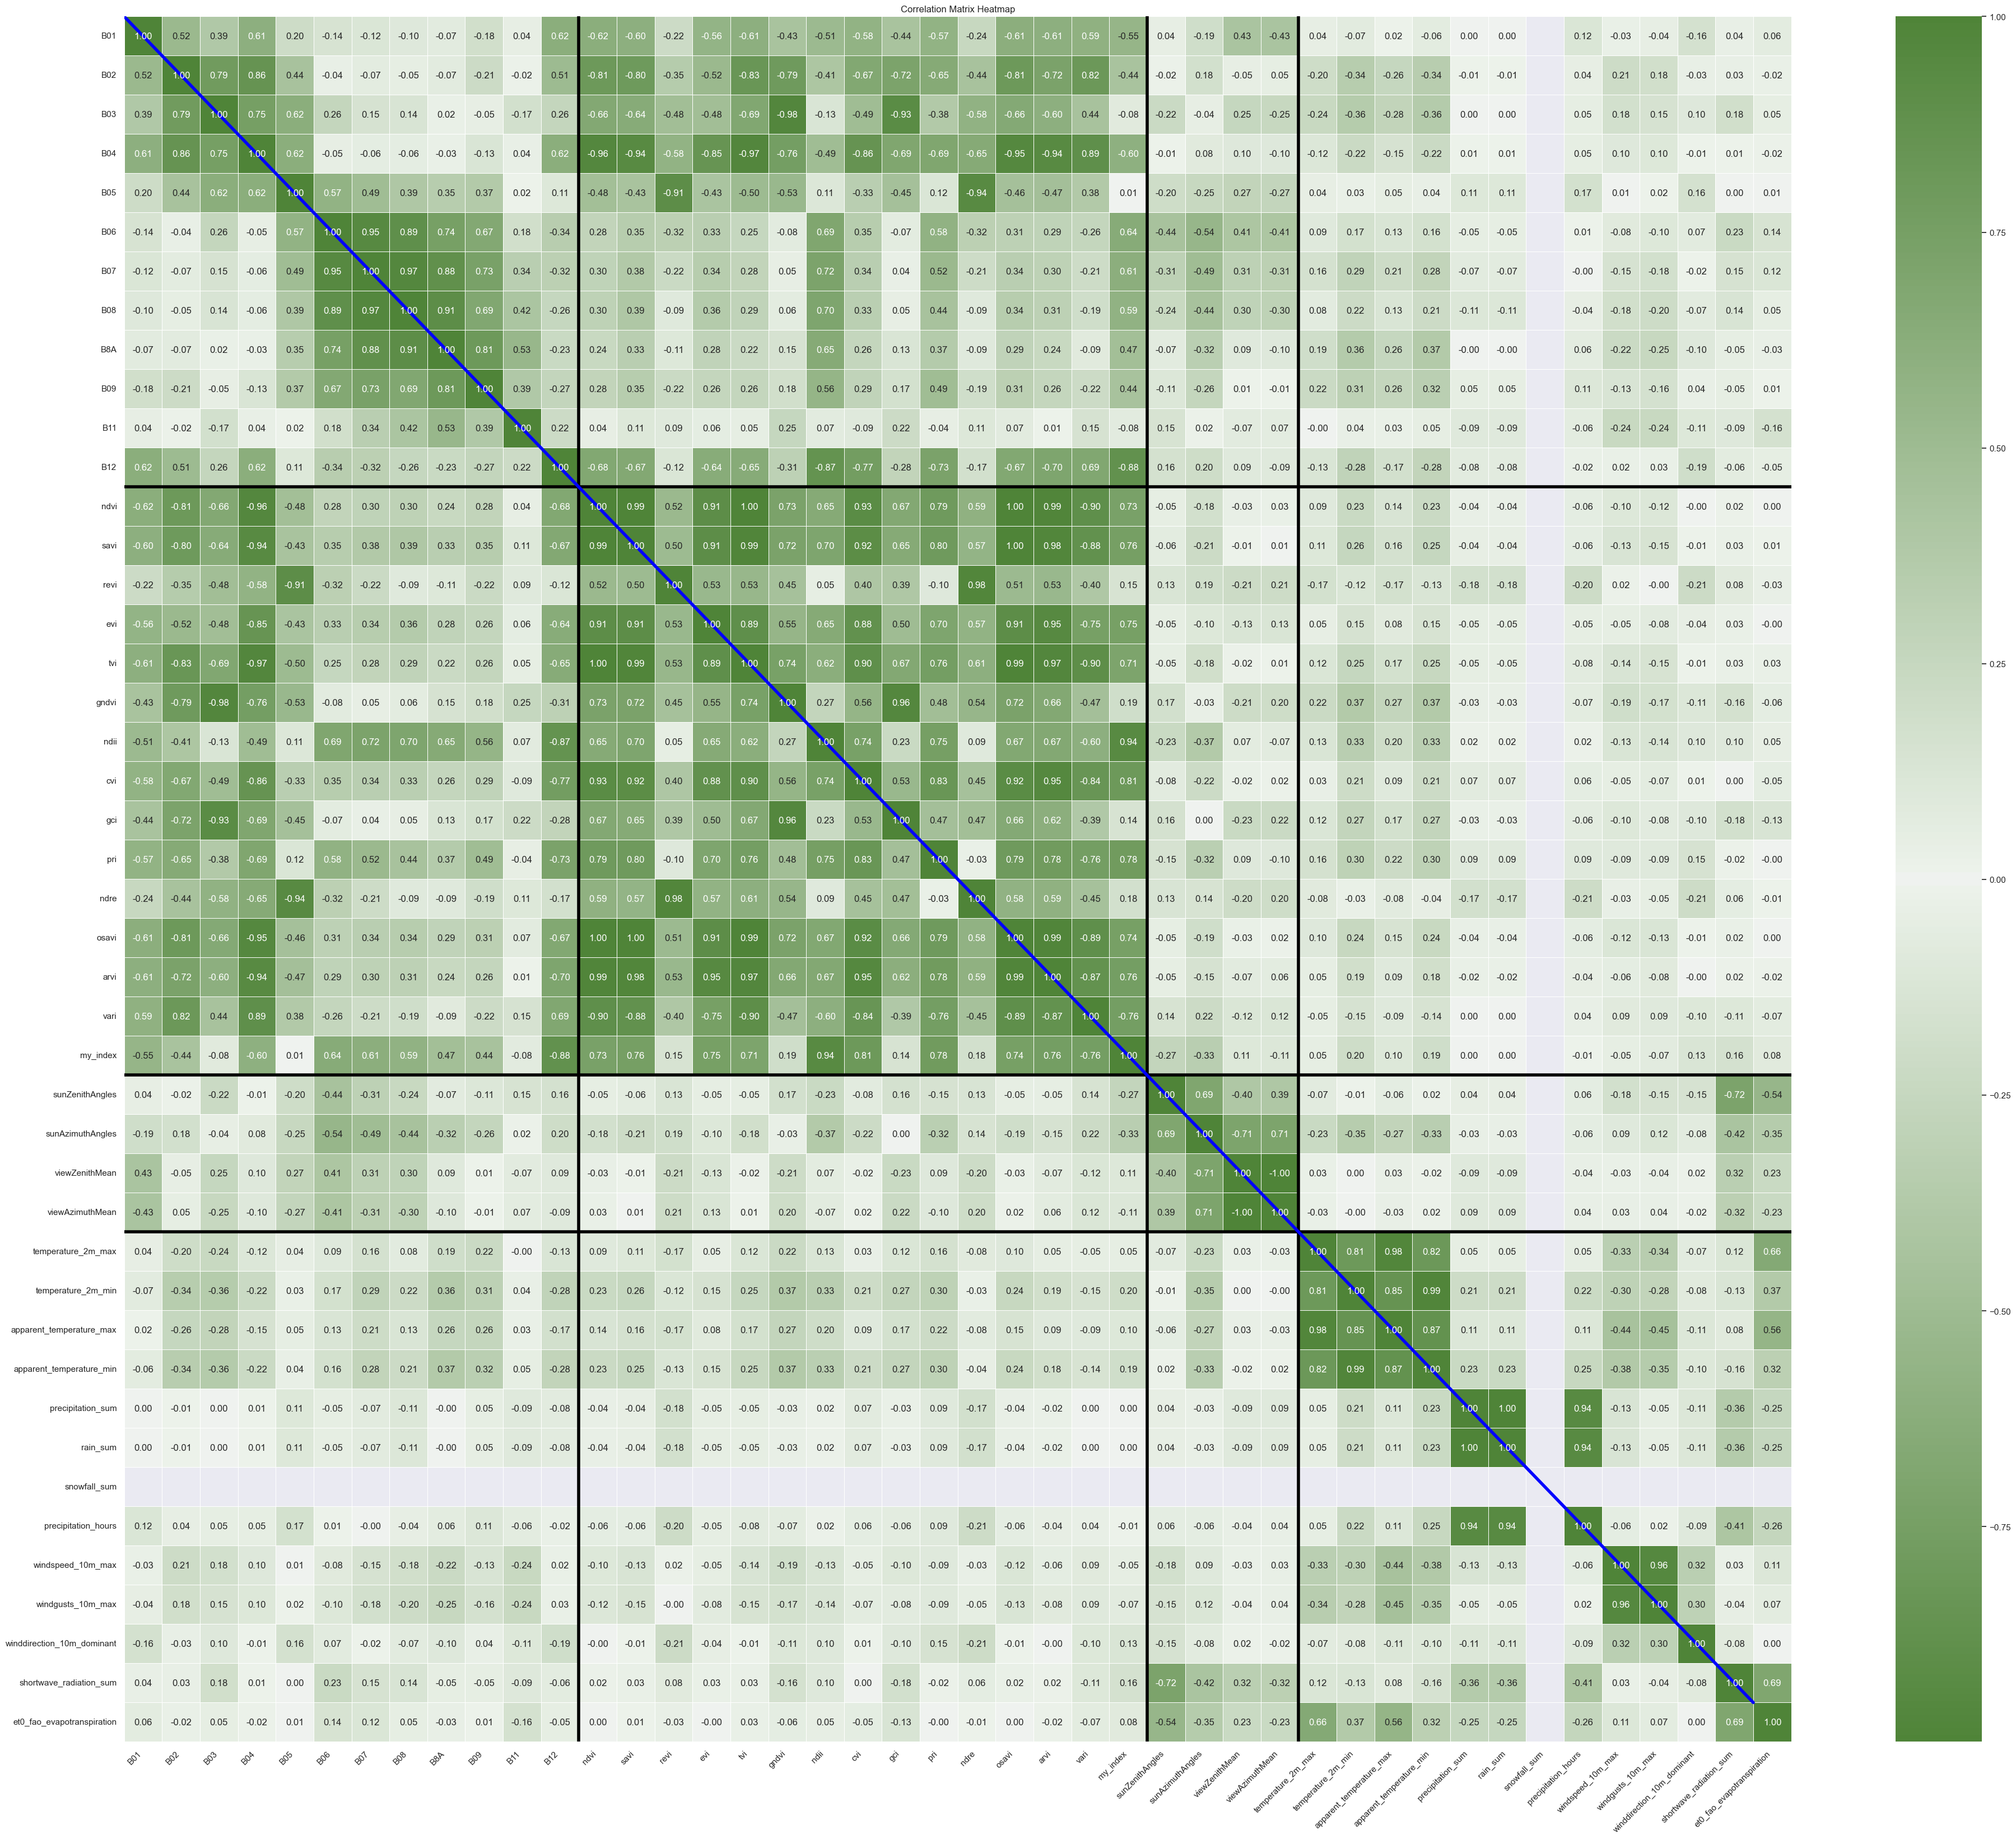

In [56]:
correlation_matrix = joined_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(48, 40))

cmap = sns.diverging_palette(120, 120, as_cmap=True)

# Plot the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Draw a separation line after the 5th column (index 4)
plt.axvline(x=12, color='black', linestyle='-', linewidth=4)
plt.axvline(x=27, color='black', linestyle='-', linewidth=4)
plt.axvline(x=31, color='black', linestyle='-', linewidth=4)

plt.axhline(y=12, color='black', linestyle='-', linewidth=4)
plt.axhline(y=27, color='black', linestyle='-', linewidth=4)
plt.axhline(y=31, color='black', linestyle='-', linewidth=4)

x = np.arange(correlation_matrix.shape[0])
plt.plot(x, x, color='blue', linestyle='-', linewidth=4)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.title("Correlation Matrix Heatmap")
plt.show()